In [1]:
from PaiNN import PainnModel
import torch

In [2]:
selftraining_model = PainnModel(
            num_interactions=6, hidden_state_size=128, cutoff=6.0, pdb=True
        )
state_dict = torch.load('Selftraining2.ckpt')["state_dict"]
new_state_dict = {k.replace("potential.", ""): v for k, v in state_dict.items()}
selftraining_model.load_state_dict(new_state_dict)
selftraining_model.eval()
base_model = PainnModel(
            num_interactions=6, hidden_state_size=128, cutoff=6.0, pdb=True
        )
state_dict = torch.load('Baseline.ckpt')["state_dict"]
new_state_dict = {k.replace("potential.", ""): v for k, v in state_dict.items()}
base_model.load_state_dict(new_state_dict)
base_model.eval()
# fine-tune from self-training model

PainnModel(
  (atom_embedding): Embedding(119, 128)
  (message_layers): ModuleList(
    (0-5): 6 x PainnMessage(
      (scalar_message_mlp): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): SiLU()
        (2): Linear(in_features=128, out_features=384, bias=True)
      )
      (filter_layer): Linear(in_features=20, out_features=384, bias=True)
    )
  )
  (update_layers): ModuleList(
    (0-5): 6 x PainnUpdate(
      (update_U): Linear(in_features=128, out_features=128, bias=True)
      (update_V): Linear(in_features=128, out_features=128, bias=True)
      (update_mlp): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): SiLU()
        (2): Linear(in_features=128, out_features=384, bias=True)
      )
    )
  )
  (readout_mlp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [3]:
finetune_dataset = torch.load('test.pt',weights_only=False)

In [4]:
from torch_geometric.loader import DataLoader
finetune_loader = DataLoader(finetune_dataset, batch_size=1, shuffle=False)

In [ ]:
from tqdm import tqdm
baseline_mae_list=[]
selftraining_model_mae_list=[]
for data in tqdm(finetune_loader):
    data.pbc=torch.as_tensor([True,True,True])
    true_forces=data.force
    pred_energy,pred_forces = base_model(data)
    mae = torch.mean((pred_forces - true_forces).norm(dim=-1))
    baseline_mae_list.append(mae.item())
    pred_energy,pred_forces = selftraining_model(data)
    selftraining_model_mae_list.append(torch.mean((pred_forces - true_forces).norm(dim=-1)).item())

  6%|▌         | 357/6000 [00:52<14:20,  6.55it/s]

In [6]:
import matplotlib.pyplot as plt
import scienceplots
import numpy as np
plt.style.use(['science','notebook','grid'])

Text(0, 0.5, 'Self-training MAE (eV/Å)')

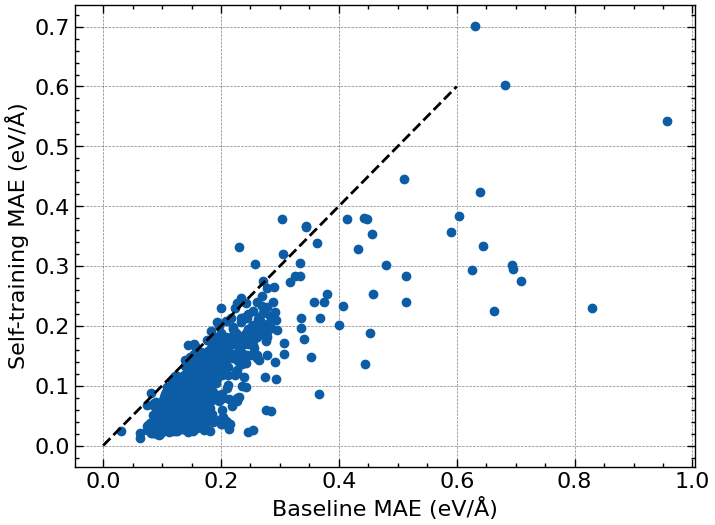

In [7]:
plt.scatter(baseline_mae_list,selftraining_model_mae_list)
plt.plot([0,0.6],[0,0.6],'k--')
plt.xlabel('Baseline MAE (eV/Å)')
plt.ylabel('Self-training MAE (eV/Å)')

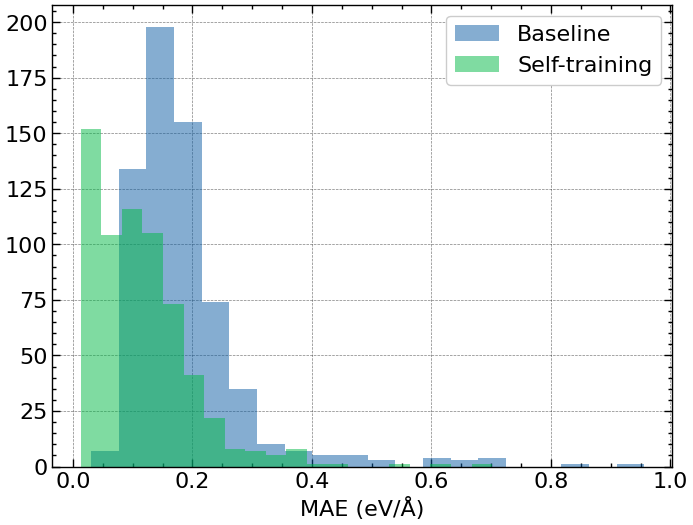

In [8]:
plt.hist(baseline_mae_list,alpha=0.5,bins=20,label='Baseline')
plt.hist(selftraining_model_mae_list,alpha=0.5,bins=20,label='Self-training')
plt.xlabel('MAE (eV/Å)')
plt.legend()